<center>
    <h1>Shortest Path Analysis on Uber Movement Data</h1>
    <h2>Architecture and Platforms of AI Project</h2>
    <h3>Mohammad Reza Ghasemi Madani</h3>
    <h4> mohammadreza.ghasemi@studio.unibo.it</h4>
</center>

---


In [2]:
import numpy as np
import networkx as nx

In [3]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [4]:
from random import seed

# Settings for riproducibility
SEED = 42
np.random.seed(SEED)
seed(SEED)

In [48]:
import os

# Important constants
CITY_NAME = 'Washington DC'
GEOJSON_PATH = os.path.join('../../data', 'los_angeles_censustracts.json')
TRAVEL_TIMES_DATA_PATH = os.path.join('../../data', 'los_angeles-censustracts-2020-1-All-HourlyAggregate.csv')

# Networks Definition
In this section the temporal network defining the mean travel times during weekdays at different hours is built along with a spatial graph defining the city structure.

## Spatial Network
A spatial network is built as an undirected graph where the node correspond to different blocks of the cities and the edges contain the distance between neighboring regions.

A `GeoJSON` file describing the coordinates of the polygons which delimit the zones in the city is imported as a `GeoDataFrame` and  exploited to build the spatial network that models the underlying city structure.

In [49]:
from utils.geodataframe import get_geodataframe

gdf = get_geodataframe(GEOJSON_PATH)

print(f'Geodataframe of {CITY_NAME}:')
gdf.head()

Geodataframe of Washington DC:


,geometry,MOVEMENT_ID,TRACT,DISPLAY_NAME
0,"POLYGON ((-118.11683 34.10722, -118.11631 34.1...",1,480302,Census Tract 480302
1,"POLYGON ((-118.13467 34.09877, -118.13464 34.0...",2,480303,Census Tract 480303
2,"POLYGON ((-118.13453 34.09157, -118.13462 34.0...",3,480304,Census Tract 480304
3,"POLYGON ((-118.12276 34.10447, -118.12386 34.1...",4,480400,Census Tract 480400
4,"POLYGON ((-118.14178 34.09877, -118.14178 34.0...",5,480500,Census Tract 480500


Centroids are computed for each area. They are subsequently used to calculate the distance among the areas and are used as reference points.

In [50]:
from utils.geodataframe import set_geodataframe_centroids

set_geodataframe_centroids(gdf)

In [51]:
print(f'Geodataframe of {CITY_NAME} after the centroid computation:')
gdf.head()

Geodataframe of Washington DC after the centroid computation:


,geometry,MOVEMENT_ID,TRACT,DISPLAY_NAME,centroid
0,"POLYGON ((-118.11683 34.10722, -118.11631 34.1...",1,480302,Census Tract 480302,POINT (-118.12180 34.10124)
1,"POLYGON ((-118.13467 34.09877, -118.13464 34.0...",2,480303,Census Tract 480303,POINT (-118.13772 34.09514)
2,"POLYGON ((-118.13453 34.09157, -118.13462 34.0...",3,480304,Census Tract 480304,POINT (-118.13160 34.09617)
3,"POLYGON ((-118.12276 34.10447, -118.12386 34.1...",4,480400,Census Tract 480400,POINT (-118.13217 34.10400)
4,"POLYGON ((-118.14178 34.09877, -118.14178 34.0...",5,480500,Census Tract 480500,POINT (-118.14534 34.09869)


The spatial network is built from the `GeoDataFrame` and its statistics are illustrated.

In [52]:
from utils.spatial_network import get_spatial_network

spatial_network = get_spatial_network(gdf)

In [53]:
print(f'Number of nodes in the spatial network: {len(spatial_network.nodes())}')
print(f'Number of edges in the spatial network: {len(spatial_network.edges())}')
print(f'Spatial network density: {nx.density(spatial_network)}')

Number of nodes in the spatial network: 2716
Number of edges in the spatial network: 8789
Spatial network density: 0.002383800247900037


In [54]:
print(f'The spatial network is directed: {nx.is_directed(spatial_network)}')

The spatial network is directed: False


Finally, the spatial network is shown below over the city map.

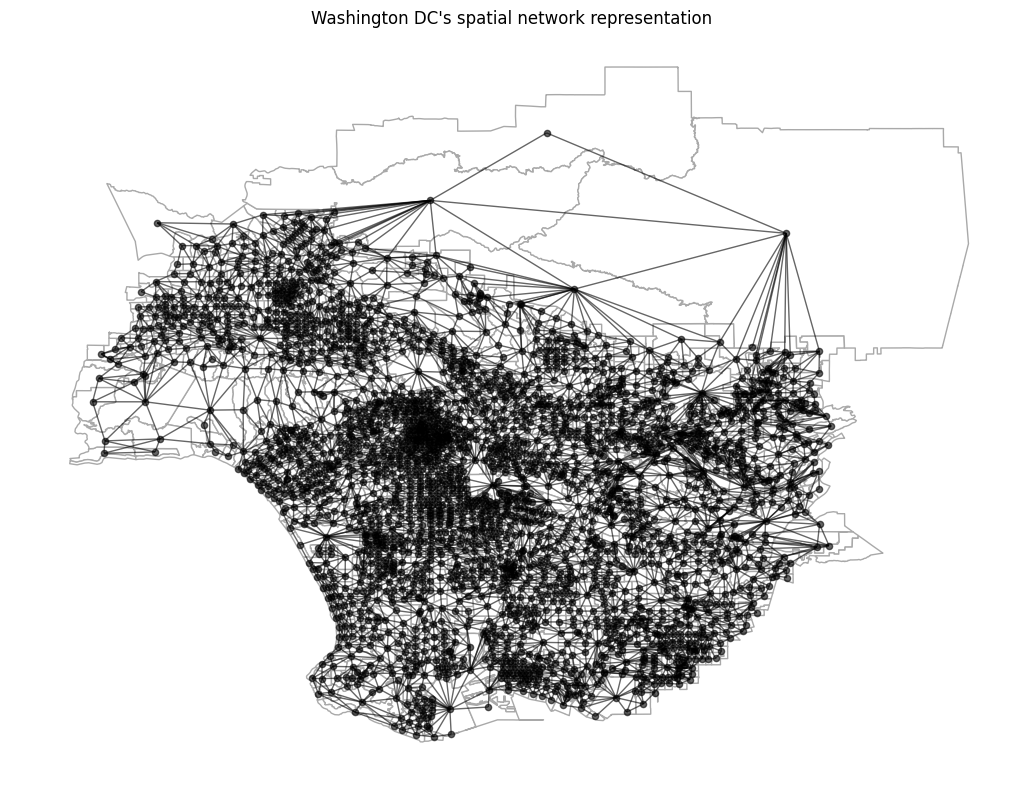

In [55]:
from utils.graphics import plot_spatial_network

plot_spatial_network(gdf, spatial_network, title=f"{CITY_NAME}'s spatial network representation")

# Temporal Network
A temporal Network with dynamic weights on the edges is defined. The nodes correspond to different regions and are a subset of the ones
present in the spatial network, while the edges include the average travel time over the different considered hours of the day across the regions. The dynamicity of the temporal network is handled by building a dictionary that for each considered hour, contains the view of the temporal network at that specific hour.

A `pandas DataFrame` containing the mean travel times among regions is initially created from the `.csv` of the *Uber Movement* data of the city.

In [56]:
from utils.temporal_network import get_movement_dataframe

df = get_movement_dataframe(TRAVEL_TIMES_DATA_PATH)

print(f"{CITY_NAME}'s movement dataframe:")
df.head()

Washington DC's movement dataframe:


,sourceid,dstid,hod,mean_travel_time
0,1155,1174,5,840.33
1,1366,1570,13,659.71
2,480,1423,2,821.79
3,450,1723,2,210.88
4,442,1803,2,978.88


The temporal network is built from the `DataFrame` and its statistics are illustrated.

In [58]:
from utils.temporal_network import get_temporal_networks_from_pandas_edgelist

temporal_networks_dict = get_temporal_networks_from_pandas_edgelist(df, [0, 8, 13, 20])

In [59]:
for k, v in temporal_networks_dict.items():
   print(f'Temporal network at time {k}: nodes: {len(v.nodes())} edges: {len(v.edges())} density: {nx.density(v)}') 

Temporal network at time 0: nodes: 2635 edges: 1030631 density: 0.14849328371219161
Temporal network at time 8: nodes: 2643 edges: 1155287 density: 0.16544738605082254
Temporal network at time 13: nodes: 2639 edges: 1192157 density: 0.1712455409482938
Temporal network at time 20: nodes: 2639 edges: 1210366 density: 0.17386114447629178


In [60]:
for k, v in temporal_networks_dict.items():
    print(f'Temporal network at time {k} is directed: {nx.is_directed(v)}') 

Temporal network at time 0 is directed: True
Temporal network at time 8 is directed: True
Temporal network at time 13 is directed: True
Temporal network at time 20 is directed: True


In [62]:
n_nodes = [len(df[df['hod']==i]) for i in df['hod'].unique()]
hod = df['hod'].unique()[np.argmax(np.array(n_nodes))]

df_hod = df[df['hod']==hod].drop(columns=['hod'])
df_hod.to_csv(f'../../data/los_angeles_temporal_at_{hod}.csv', header=False, index=False)

In [63]:
df_hod.describe(include='all')

,sourceid,dstid,mean_travel_time
count,1277165,1277165,1.277165e+06
unique,2638,2644,NaN
top,1697,1697,NaN
freq,2202,2093,NaN
mean,NaN,NaN,1.515920e+03
std,NaN,NaN,7.411789e+02
min,NaN,NaN,3.280000e+00
25%,NaN,NaN,9.688800e+02
50%,NaN,NaN,1.430170e+03
75%,NaN,NaN,1.979830e+03
